# Prediction of the number of migrations between two districts per year OLS

In [1]:
import math
import lxml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/pop_dyn/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def normalize_features(data, features):
    for feature in features:
        scaler = StandardScaler(with_mean=0, with_std=1)
        data[feature] = scaler.fit_transform(data[feature])
    return data

def split_train_test_by_quartiles(feature_vector, feature_columns, target_column, n_splits_dist, labels, train_size):
    X = feature_vector.loc[:, (feature_columns)]
    y = feature_vector.loc[:, target_column]
    
    # extract quartiles from continuous target to equally split between train/test
    label_list = pd.qcut(feature_vector[target_column], n_splits_dist, labels=labels).tolist()
    
    # Split train/test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=32, 
                                                                  stratify=label_list)
    return X_train, X_test, y_train, y_test

def split_x_y(data, x_columns, y_column):
    X = data.loc[:,(x_columns)]
    Y = data.loc[:,(y_column)]
    return X, Y

In [3]:
f_vector = pd.read_csv("../feature_extraction/data/feature_vector_complete.csv")

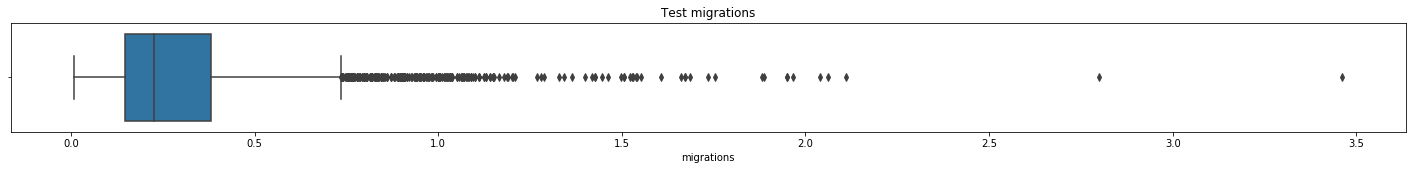

In [4]:
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(f_vector['migrations'])

In [5]:
f_vector[f_vector['migrations'] > 2.5]

,migrations,destination,origin,year,n_inhabitants_or,net_income_or,euribor,density_or,rev_1000_inh_or,var_review_or,...,rev_1000_inh_diff,var_review_diff,unemployed_diff,eldery_perc_diff,d_inner_n_diff,d_outer_n_diff,var_sale_m2_diff,var_rent_m2_diff,n_tran_rs_diff,n_tran_new_rs_diff
316,3.461478,Villa de Vallecas,Puente de Vallecas,2007,461817.0,23405.03,4.064,152.05,0.0,0.0,...,0.0,0.0,-0.076640,-5.222267,3.178951,-0.369562,0.113030,1.609018,16.677943,16.677943
1076,2.799199,Villa de Vallecas,Puente de Vallecas,2009,469133.0,23405.03,2.622,152.05,0.0,0.0,...,0.0,0.0,-0.111384,-5.991983,3.770764,-0.435502,5.080003,2.850579,18.237017,18.237017


In [6]:
# Remove the two outliers with values higher than 50
f_vector = f_vector[f_vector['migrations'] < 2.5] 

In [7]:
f_vector.columns

Index(['migrations', 'destination', 'origin', 'year', 'n_inhabitants_or',
       'net_income_or', 'euribor', 'density_or', 'rev_1000_inh_or',
       'var_review_or', 'unemployed_or', 'eldery_perc_or', 'd_inner_n_or',
       'd_outer_n_or', 'var_n_biz', 'var_sale_m2_or', 'var_rent_m2_or',
       'n_tran_rs_or', 'n_tran_new_rs_or', 'mortage_executions',
       'n_inhabitants_de', 'net_income_de', 'density_de', 'rev_1000_inh_de',
       'var_review_de', 'unemployed_de', 'eldery_perc_de', 'd_inner_n_de',
       'd_outer_n_de', 'var_sale_m2_de', 'var_rent_m2_de', 'n_tran_rs_de',
       'n_tran_new_rs_de', 'net_income_diff', 'density_diff',
       'rev_1000_inh_diff', 'var_review_diff', 'unemployed_diff',
       'eldery_perc_diff', 'd_inner_n_diff', 'd_outer_n_diff',
       'var_sale_m2_diff', 'var_rent_m2_diff', 'n_tran_rs_diff',
       'n_tran_new_rs_diff'],
      dtype='object')

In [8]:
f_vector.loc[f_vector[f_vector['year'] <= 2008].index, 'period'] = 0
f_vector.loc[f_vector[(f_vector['year'] > 2008) & (f_vector['year'] <= 2011)].index, 'period'] = 2
f_vector.loc[f_vector[f_vector['year'] > 2011].index, 'period'] = 1

In [9]:
feature_columns = ['net_income_or', 'density_or', 'rev_1000_inh_or', 'unemployed_or', 'eldery_perc_or', 
                   'var_sale_m2_or', 'var_rent_m2_or', 'n_tran_new_rs_or', 'var_review_or',
                   'n_tran_new_rs_de', "mortage_executions" , 'euribor', 'var_n_biz',
                   'net_income_de', 'rev_1000_inh_de', 'var_review_de', 'unemployed_de','eldery_perc_de', 
                   "var_sale_m2_de", "var_rent_m2_de", "density_de", 'n_tran_rs_or',
                   'n_tran_rs_de']
target_column = "migrations"
n_splits_dist = 5
labels = ["q1","q2","q3","q4","q5"]
train_size = 0.9
alpha = 0.05

### One Hot Encode year

In [10]:
f_vector['year'] = f_vector['year'].astype('category')
f_vector = pd.get_dummies(f_vector, columns=["year"])

In [11]:
f_vector.columns

Index(['migrations', 'destination', 'origin', 'n_inhabitants_or',
       'net_income_or', 'euribor', 'density_or', 'rev_1000_inh_or',
       'var_review_or', 'unemployed_or', 'eldery_perc_or', 'd_inner_n_or',
       'd_outer_n_or', 'var_n_biz', 'var_sale_m2_or', 'var_rent_m2_or',
       'n_tran_rs_or', 'n_tran_new_rs_or', 'mortage_executions',
       'n_inhabitants_de', 'net_income_de', 'density_de', 'rev_1000_inh_de',
       'var_review_de', 'unemployed_de', 'eldery_perc_de', 'd_inner_n_de',
       'd_outer_n_de', 'var_sale_m2_de', 'var_rent_m2_de', 'n_tran_rs_de',
       'n_tran_new_rs_de', 'net_income_diff', 'density_diff',
       'rev_1000_inh_diff', 'var_review_diff', 'unemployed_diff',
       'eldery_perc_diff', 'd_inner_n_diff', 'd_outer_n_diff',
       'var_sale_m2_diff', 'var_rent_m2_diff', 'n_tran_rs_diff',
       'n_tran_new_rs_diff', 'period', 'year_2007', 'year_2008', 'year_2009',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015', '

### Build train/test data sets

In [12]:
# Scale features
feature_vector = normalize_features(f_vector, feature_columns)
feature_vector['period'] = feature_vector['period'].astype(int)
cat_features = ['year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 
                'year_2014', 'year_2015', 'year_2016']

# Split by features and target
X, Y = split_x_y(feature_vector, feature_columns + cat_features, target_column)

In [13]:
X.shape

(3798, 33)

## Model considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [14]:
X_total = X.copy()#.drop(['period'], axis=1)

# Add baseline
X_ = sm.add_constant(X_total.as_matrix())

# Train linear regression and predict migrations
mod = sm.OLS(exog =X_, endog=np.array(Y.astype(float))).fit()
y_pred = mod.predict(np.array(X_).astype(float))
summary = mod.summary(xname=feature_columns + cat_features)

In [15]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     21.03
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           7.42e-95
Time:                        20:39:27   Log-Likelihood:                 126.77
No. Observations:                3798   AIC:                            -197.5
Df Residuals:                    3770   BIC:                            -22.76
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_or          0.0199      0.027      0.738      0.460      -0.033       0.073
density_or             0.0195      0.008      2.291      0.022       0.003       0.036
rev_1000_inh_or        0.0722      0.005     13.402      0.000       0.062       0.083
unemployed_or          0.0146      0.004      3.426      0.001       0.006       0.023
eldery_perc_or         0.0163      0.011      1.486      0.137      -0.005       0.038
var_sale_m2_or        -0.0193      0.006     -3.371      0.001      -0.031      -0.008
var_rent_m2_or        -0.0088      0.008     -1.061      0.289      -0.025       0.007
n_tran_new_rs_or      -0.0017      0.007     -0.232      0.816      -0.016       0.012
var_review_or         -0.0014      0.002     -0.674      0.500      -0.006       0.003
n_tran_new_rs_de       0.0039      0.004      0.960      0.337      -0.004       0.012
mortage_executions     0.0215      0.002     10.272      0.000       0.017       0.026
euribor                0.0198      0.023      0.871      0.384      -0.025       0.064
var_n_biz              0.0240      0.013      1.910      0.056      -0.001       0.049
net_income_de          0.0237      0.020      1.216      0.224      -0.015       0.062
rev_1000_inh_de        0.0171      0.008      2.010      0.045       0.000       0.034
var_review_de         -0.0040      0.004     -0.940      0.347      -0.012       0.004
unemployed_de          0.0014      0.004      0.342      0.733      -0.007       0.009
eldery_perc_de         0.0260      0.011      2.371      0.018       0.004       0.047
var_sale_m2_de        -0.0323      0.006     -5.645      0.000      -0.044      -0.021
var_rent_m2_de        -0.0114      0.008     -1.383      0.167      -0.028       0.005
density_de             0.0059      0.007      0.824      0.410      -0.008       0.020
n_tran_rs_or           0.0439      0.005      8.146      0.000       0.033       0.054
n_tran_rs_de          -0.0014      0.002     -0.674      0.500      -0.006       0.003
year_2007              0.0215      0.002     10.272      0.000       0.017       0.026
year_2008              0.0219      0.011      2.024      0.043       0.001       0.043
year_2009             -0.0160      0.013     -1.261      0.207      -0.041       0.009
year_2010              0.0255      0.015      1.650      0.099      -0.005       0.056
year_2011              0.0295      0.017      1.690      0.091      -0.005       0.064
year_2012             -0.0012      0.016     -0.071      0.943      -0.033       0.031
year_2013             -0.0371      0.015     -2.550      0.011      -0.066      -0.009
year_2014             -0.0245      0.016     -1.530      0.126      -0.056       0.007
year_2015             -0.0036      0.021     -0.172      0.864      -0.045       0.037
year_2016          -7.995e-05      0.0

In [16]:
pd.read_html(summary.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls.csv",
                                              index=True, encoding='utf-8')

In [17]:
summary = pd.read_csv("../feature_extraction/data/results_gls.csv").rename(columns={'Unnamed: 0':'features'})
summary = summary.sort_values(by="P>|t|", ascending=False)
summary = summary.rename(columns={'P>|t|':'P-value'})

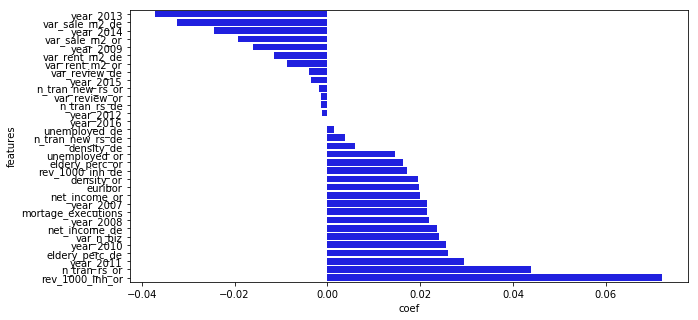

In [18]:
significant_factors = summary.copy()
significant_factors = significant_factors.sort_values(by="coef")
plt.figure(figsize=(10, 5))
sns.barplot(y="features",x="coef",data=significant_factors, color="blue")

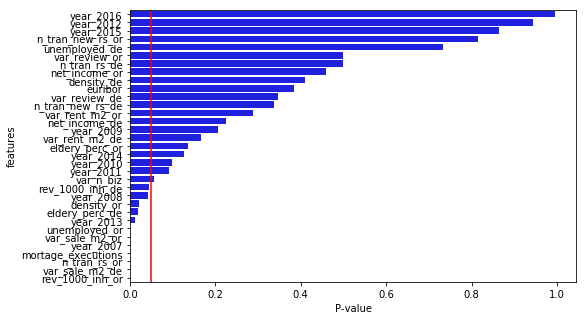

In [19]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary, color="blue")
plt.axvline(x=alpha, color="red")

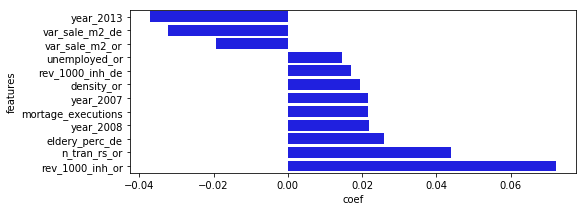

In [20]:
significant_factors = summary[summary["P-value"] < alpha]
significant_factors = significant_factors.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors, color="blue")

### Evaluate performance of the model

In [21]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(Y, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(Y, y_pred)))

The RMSE in the test data set is: 0.23
 The r2 score in the test data set is: 0.13


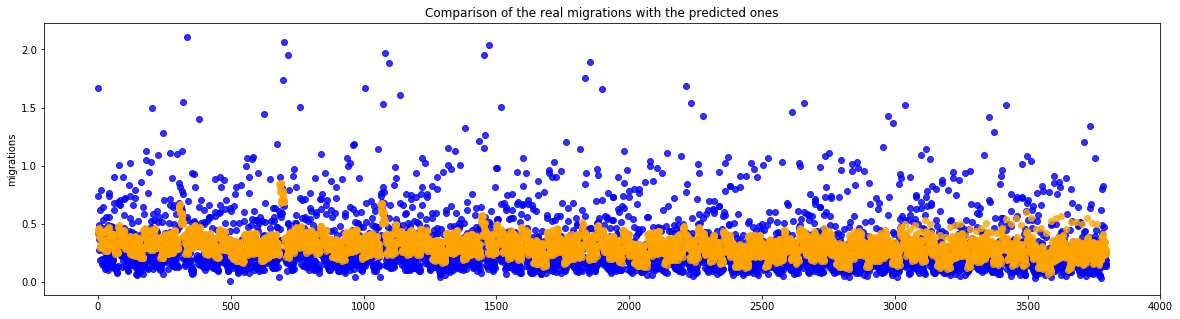

In [22]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(Y)), y=Y, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

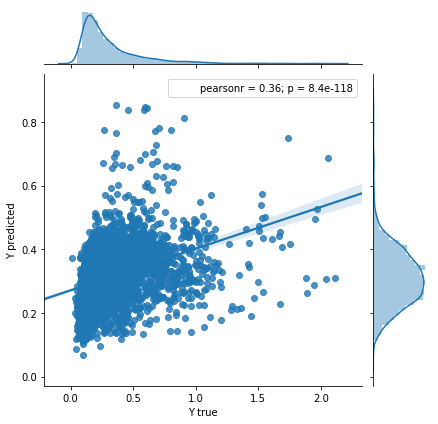

In [23]:
_=sns.jointplot(x=Y, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Compare factors correlation with the internal migrations per period (pre, during, after crisis)

### Linear model until the economical crisis 2008

In [24]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_b = f_vector[f_vector['period']==0]
feature_columns_ = [x for x in feature_columns if x not in ['period', 'rev_1000_inh_or','var_review_or',
                                                            'rev_1000_inh_de','var_review_de']]
feature_vector_b_ = normalize_features(feature_vector_b, feature_columns_)

# Split by features and target
X_b, Y_b = split_x_y(feature_vector_b_, feature_columns_, target_column)

# Add baseline
X_b_ = sm.add_constant(X_b.as_matrix())

# Train linear regression and predict migrations
mod_b = sm.OLS(exog =X_b_, endog=np.array(Y_b.astype(float))).fit()
y_pred_b = mod_b.predict(np.array(X_b_).astype(float))
summary_b = mod_b.summary(xname=feature_columns_)

In [25]:
summary_b

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     8.557
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           2.46e-18
Time:                        20:39:33   Log-Likelihood:                -20.957
No. Observations:                 759   AIC:                             73.91
Df Residuals:                     743   BIC:                             148.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_or         -0.0002      0.001     -0.194      0.846      -0.002       0.001
density_or             0.0262      0.026      0.991      0.322      -0.026       0.078
unemployed_or          0.0718      0.017      4.237      0.000       0.039       0.105
eldery_perc_or         0.0319      0.025      1.300      0.194      -0.016       0.080
var_sale_m2_or        -0.0170      0.016     -1.046      0.296      -0.049       0.015
var_rent_m2_or        -0.0069      0.019     -0.365      0.715      -0.044       0.030
n_tran_new_rs_or      -0.0099      0.011     -0.924      0.356      -0.031       0.011
n_tran_new_rs_de      -0.0062      0.006     -1.111      0.267      -0.017       0.005
mortage_executions     0.0260      0.006      4.650      0.000       0.015       0.037
euribor               -0.0116      0.004     -2.713      0.007      -0.020      -0.003
var_n_biz             -0.0142      0.013     -1.066      0.287      -0.040       0.012
net_income_de          0.0106      0.007      1.430      0.153      -0.004       0.025
unemployed_de          0.0444      0.026      1.681      0.093      -0.007       0.096
eldery_perc_de         0.0626      0.025      2.554      0.011       0.014       0.111
var_sale_m2_de        -0.0345      0.016     -2.126      0.034      -0.066      -0.003
var_rent_m2_de        -0.0098      0.019     -0.516      0.606      -0.047       0.027
density_de            -0.0060      0.011     -0.560      0.575      -0.027       0.015
n_tran_rs_or           0.0438      0.017      2.588      0.010       0.011       0.077
n_tran_rs_de          -0.0062      0.006     -1.111      0.267      -0.017       0.005
==============================================================================
Omnibus:                      444.065   Durbin-Watson:                   1.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3888.457
Skew:                           2.552   Prob(JB):                         0.00
Kurtosis:                      12.844   Cond. No.                     3.05e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.58e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [26]:
pd.read_html(summary_b.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_b_crisis.csv",
                                              index=True, encoding='utf-8')

In [27]:
summary_b = pd.read_csv("../feature_extraction/data/results_gls_b_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_b = summary_b.sort_values(by="P>|t|", ascending=False)
summary_b = summary_b.rename(columns={'P>|t|':'P-value'})

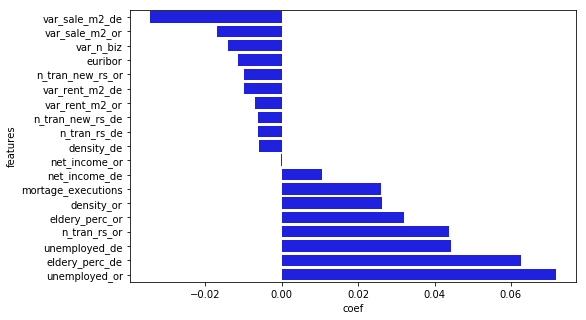

In [28]:
significant_factors_b = summary_b.copy()
significant_factors_b = significant_factors_b.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_b, color="blue")

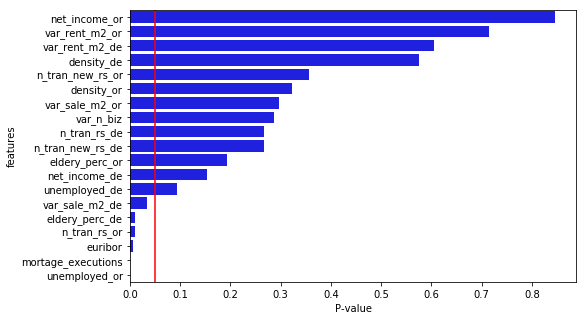

In [29]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_b, color="blue")
plt.axvline(x=alpha, color="red")

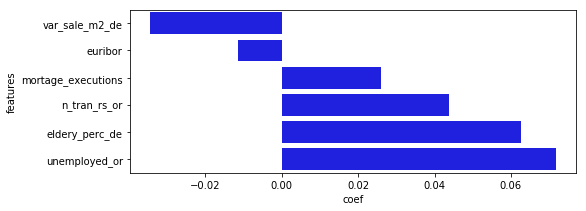

In [30]:
significant_factors_b = summary_b[summary_b["P-value"] < alpha]
significant_factors_b = significant_factors_b.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_b, color="blue")

In [31]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(Y_b, y_pred_b))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(Y_b, y_pred_b)))

The RMSE in the test data set is: 0.25
 The r2 score in the test data set is: 0.15


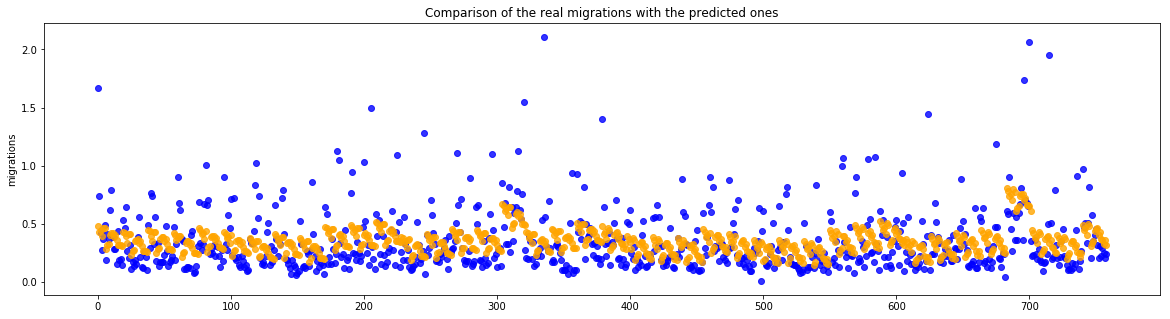

In [32]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(Y_b)), y=Y_b, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_b)), y=y_pred_b, fit_reg=False, color="orange")

### Linear model during the crisis 2009-2011

In [33]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_d = f_vector[f_vector['period']==2]
feature_columns_ = [x for x in feature_columns if x not in ['period', 'rev_1000_inh_or','var_review_or',
                                                            'rev_1000_inh_de','var_review_de']]
feature_vector_d_ = normalize_features(feature_vector_d, feature_columns_)

# Split by features and target
X_d, Y_d = split_x_y(feature_vector_d_, feature_columns_, target_column)

# Add baseline
X_d_ = sm.add_constant(X_d.as_matrix())

# Train linear regression and predict migrations
mod_d = sm.OLS(exog =X_d_, endog=np.array(Y_d.astype(float))).fit()
y_pred_d = mod_d.predict(np.array(X_d_).astype(float))
summary_d = mod_d.summary(xname=feature_columns_)

In [34]:
X_d_.shape

(1139, 20)

In [35]:
summary_d

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     11.11
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           5.23e-27
Time:                        20:39:38   Log-Likelihood:                -8.7170
No. Observations:                1139   AIC:                             51.43
Df Residuals:                    1122   BIC:                             137.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_or         -0.0361      0.026     -1.412      0.158      -0.086       0.014
density_or             0.0418      0.019      2.168      0.030       0.004       0.080
unemployed_or          0.0805      0.011      7.615      0.000       0.060       0.101
eldery_perc_or         0.0463      0.021      2.215      0.027       0.005       0.087
var_sale_m2_or        -0.0188      0.011     -1.634      0.103      -0.041       0.004
var_rent_m2_or        -0.0019      0.015     -0.124      0.901      -0.032       0.028
n_tran_new_rs_or      -0.0030      0.015     -0.194      0.846      -0.033       0.027
n_tran_new_rs_de      -0.0057      0.004     -1.345      0.179      -0.014       0.003
mortage_executions     0.0238      0.004      5.607      0.000       0.015       0.032
euribor               -0.0700      0.052     -1.355      0.176      -0.171       0.031
var_n_biz              0.0459      0.030      1.508      0.132      -0.014       0.106
net_income_de         -0.0747      0.054     -1.377      0.169      -0.181       0.032
unemployed_de          0.0275      0.019      1.426      0.154      -0.010       0.065
eldery_perc_de         0.0461      0.021      2.206      0.028       0.005       0.087
var_sale_m2_de        -0.0282      0.011     -2.460      0.014      -0.051      -0.006
var_rent_m2_de         0.0003      0.015      0.022      0.982      -0.030       0.030
density_de            -0.0009      0.015     -0.061      0.951      -0.031       0.029
n_tran_rs_or           0.0455      0.011      4.305      0.000       0.025       0.066
n_tran_rs_de          -0.0057      0.004     -1.345      0.179      -0.014       0.003
==============================================================================
Omnibus:                      675.054   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6277.878
Skew:                           2.639   Prob(JB):                         0.00
Kurtosis:                      13.219   Cond. No.                     4.15e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.23e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
pd.read_html(summary_d.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_d_crisis.csv",
                                              index=True, encoding='utf-8')

In [37]:
summary_d = pd.read_csv("../feature_extraction/data/results_gls_d_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_d = summary_d.sort_values(by="P>|t|", ascending=False)
summary_d = summary_d.rename(columns={'P>|t|':'P-value'})

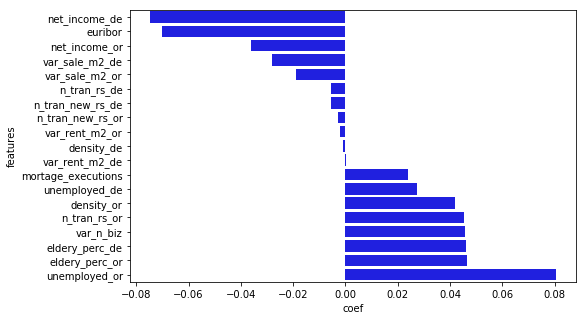

In [38]:
significant_factors_d = summary_d.copy()
significant_factors_d = significant_factors_d.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_d, color="blue")

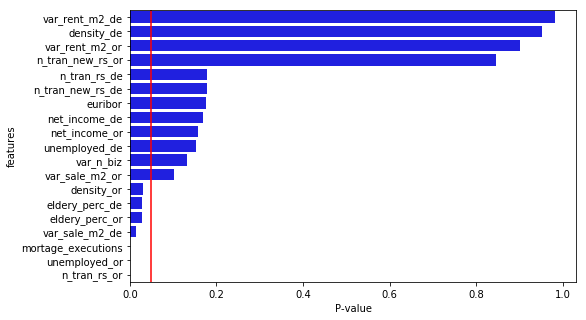

In [39]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_d, color="blue")
plt.axvline(x=alpha, color="red")

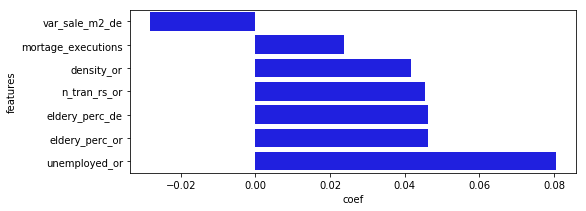

In [40]:
significant_factors_d = summary_d[summary_d["P-value"] < alpha]
significant_factors_d = significant_factors_d.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_d, color="blue")

In [41]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(Y_d, y_pred_d))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(Y_d, y_pred_d)))

The RMSE in the test data set is: 0.24
 The r2 score in the test data set is: 0.14


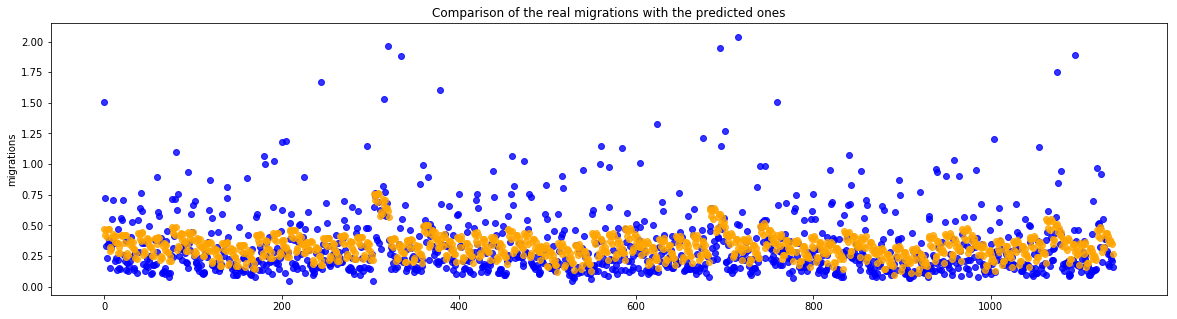

In [42]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(Y_d)), y=Y_d, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_d)), y=y_pred_d, fit_reg=False, color="orange")

### Linear model after the european crisis of 2011

In [43]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_a = f_vector[f_vector['period']==1]
feature_columns_ = [x for x in feature_columns if x not in ['period']]
feature_vector_a_ = normalize_features(feature_vector_a, feature_columns_)

# Split by features and target
X_a, Y_a = split_x_y(feature_vector_a_, feature_columns_, target_column)

# Add baseline
X_a_ = sm.add_constant(X_a.as_matrix())

# Train linear regression and predict migrations
mod_a = sm.OLS(exog =X_a_, endog=np.array(Y_a.astype(float))).fit()
y_pred_a = mod_a.predict(np.array(X_a_).astype(float))
summary_a = mod_a.summary(xname=feature_columns_)

In [44]:
X_a_.shape

(1900, 24)

In [45]:
summary_a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     11.95
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           1.88e-38
Time:                        20:39:43   Log-Likelihood:                 190.55
No. Observations:                1900   AIC:                            -337.1
Df Residuals:                    1878   BIC:                            -215.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_or         -0.2276      0.181     -1.259      0.208      -0.582       0.127
density_or             0.0380      0.013      2.894      0.004       0.012       0.064
rev_1000_inh_or        0.0701      0.007      9.546      0.000       0.056       0.084
unemployed_or          0.0178      0.006      2.911      0.004       0.006       0.030
eldery_perc_or         0.0292      0.014      2.156      0.031       0.003       0.056
var_sale_m2_or        -0.0190      0.007     -2.602      0.009      -0.033      -0.005
var_rent_m2_or         0.0035      0.012      0.292      0.770      -0.020       0.027
n_tran_new_rs_or       0.0061      0.015      0.405      0.686      -0.023       0.036
var_review_or          0.0020      0.004      0.530      0.596      -0.005       0.009
n_tran_new_rs_de      -0.0001      0.005     -0.022      0.982      -0.010       0.010
mortage_executions     0.0034      0.004      0.905      0.365      -0.004       0.011
euribor                0.0171      0.036      0.476      0.634      -0.053       0.088
var_n_biz              0.0080      0.014      0.562      0.574      -0.020       0.036
net_income_de          0.0117      0.010      1.114      0.266      -0.009       0.032
rev_1000_inh_de        0.0445      0.013      3.389      0.001       0.019       0.070
var_review_de         -0.0027      0.006     -0.434      0.664      -0.015       0.009
unemployed_de          0.0016      0.005      0.307      0.759      -0.009       0.012
eldery_perc_de         0.0416      0.014      3.069      0.002       0.015       0.068
var_sale_m2_de        -0.0318      0.007     -4.343      0.000      -0.046      -0.017
var_rent_m2_de        -0.0003      0.012     -0.022      0.982      -0.024       0.024
density_de             0.0048      0.015      0.319      0.750      -0.025       0.034
n_tran_rs_or           0.0502      0.007      6.839      0.000       0.036       0.065
n_tran_rs_de           0.0020      0.004      0.530      0.596      -0.005       0.009
==============================================================================
Omnibus:                      901.952   Durbin-Watson:                   1.411
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4833.712
Skew:                           2.240   Prob(JB):                         0.00
Kurtosis:                       9.402   Cond. No.                     2.99e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.36e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [46]:
pd.read_html(summary_a.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_a_crisis.csv",
                                              index=True, encoding='utf-8')

In [47]:
summary_a = pd.read_csv("../feature_extraction/data/results_gls_a_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_a = summary_a.sort_values(by="P>|t|", ascending=False)
summary_a = summary_a.rename(columns={'P>|t|':'P-value'})

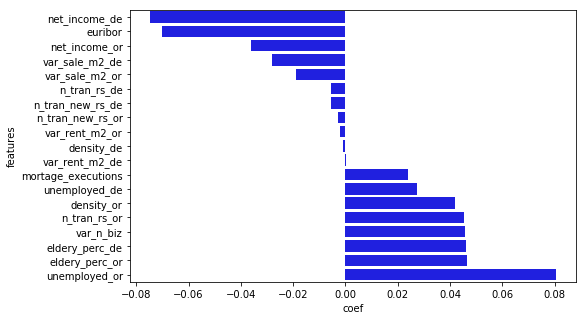

In [48]:
significant_factors_a = summary_d.copy()
significant_factors_a = significant_factors_a.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_a, color="blue")

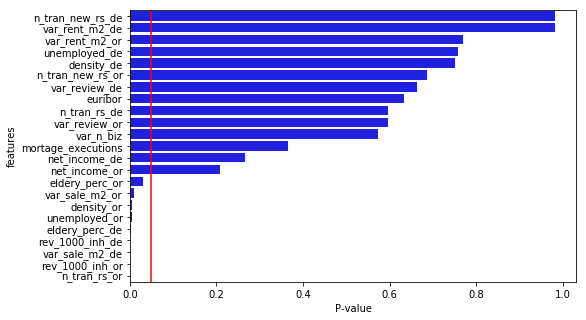

In [49]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_a, color="blue")
plt.axvline(x=alpha, color="red")

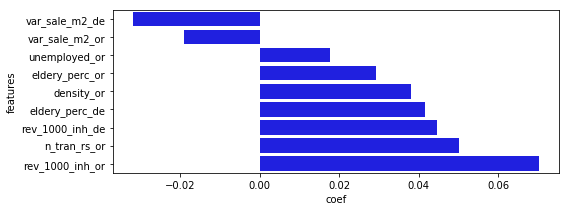

In [50]:
significant_factors_a = summary_a[summary_a["P-value"] < alpha]
significant_factors_a = significant_factors_a.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_a, color="blue")

In [51]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(Y_a, y_pred_a))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(Y_a, y_pred_a)))

The RMSE in the test data set is: 0.22
 The r2 score in the test data set is: 0.12


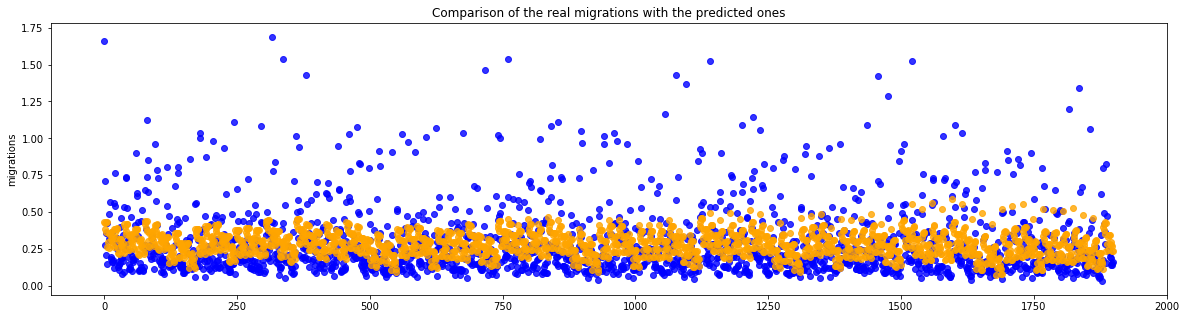

In [52]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(Y_a)), y=Y_a, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_a)), y=y_pred_a, fit_reg=False, color="orange")

## Comparison of factors overall and per period

In [53]:
set(significant_factors.features.tolist() + significant_factors_a.features.tolist() + \
              significant_factors_d.features.tolist() + significant_factors_b.features.tolist())

{'density_or',
 'eldery_perc_de',
 'eldery_perc_or',
 'euribor',
 'mortage_executions',
 'n_tran_rs_or',
 'rev_1000_inh_de',
 'rev_1000_inh_or',
 'unemployed_or',
 'var_sale_m2_de',
 'var_sale_m2_or',
 'year_2007',
 'year_2008',
 'year_2013'}

In [57]:
# Define unique existing factors and output structure
factors = set(significant_factors.features.tolist() + significant_factors_a.features.tolist() + \
              significant_factors_d.features.tolist() + significant_factors_b.features.tolist())

factors_ = ['eldery_perc_de', 'eldery_perc_or', 'density_or', 
            'unemployed_or', 'rev_1000_inh_de', 'rev_1000_inh_or', 'n_tran_rs_or', 'var_sale_m2_de', 
            'var_sale_m2_or', 'year_2007', 'year_2008', 'year_2013', 'mortage_executions', 'euribor',]

# Assign coeficient values to each period
period_names = ['whole period', 'before_crisis', "between_crisis", "after_crisis"]
periods = [significant_factors, significant_factors_b, significant_factors_d, significant_factors_a]
results = []
for period in range(len(periods)):
    df = periods[period].loc[:,('features','coef')]
    df['period'] = period_names[period]
    results.append(df)
significant_facts = pd.concat(results)
significant_facts["features"] = significant_facts["features"].astype("category", categories=factors_, ordered=True)
significant_facts = significant_facts.dropna()

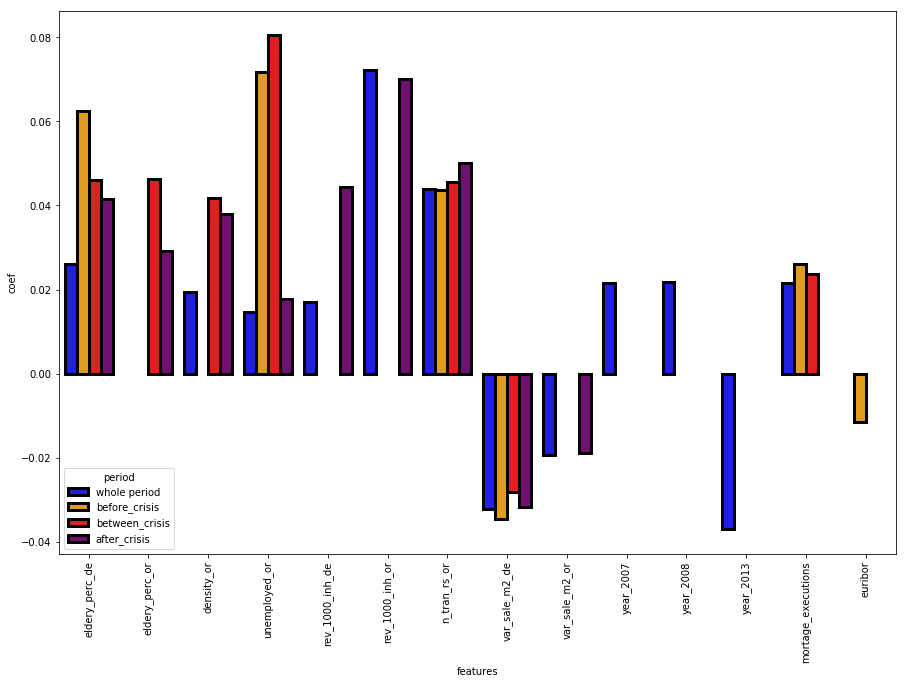

In [58]:
_=plt.figure(figsize=(15, 10))
_=sns.barplot(x='features',y='coef',data=significant_facts, hue='period', palette=['blue','orange','red','purple'],
              linewidth=3, edgecolor='black')
_=plt.xticks(rotation=90)

Text(0.5,1,'2007-2016')

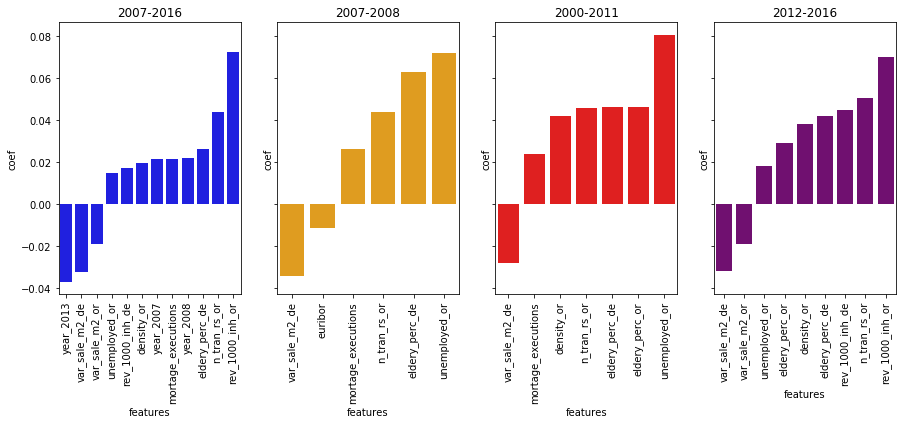

In [59]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(15,5))
sns.barplot(x='features',y='coef',data=significant_factors_b,color='orange',label='before crisis', ax=ax2)
sns.barplot(x='features',y='coef',data=significant_factors_d,color='red',label='during crisis', ax=ax3)
sns.barplot(x='features',y='coef',data=significant_factors_a,color='purple',label='after crisis', ax=ax4)
sns.barplot(x='features',y='coef',data=significant_factors,color='blue',label='after crisis', ax=ax1)
for i,ax in enumerate(f.axes):
    plt.sca(ax)
    plt.xticks(rotation=90)
ax2.set_title("2007-2008")
ax3.set_title("2000-2011")
ax4.set_title("2012-2016")
ax1.set_title("2007-2016")